In [ ]:
## HW 3
### Due Apr. 15th by end of day.
### Name your notebook by firstname.lastname.hw3.ipynb and email it to zhang@csc.lsu.edu

In this HW, we take a look at text processing using RNN based on LSTM. Given a review (hundred to thousand words long) about a movie, we want to classify the review as positive or negative (sentiment analysis). A model is given in this notebook that runs RNN, consisting of a single layer of LSTM cells, on the word sequence of the rewiews. Each review is transformed into a vector, which is the average of the LSTM vectors over the sequence. A softmax layer is then used to classify the reviews based on the LSTM vector representation. 

Your goal is to train the model and gain some idea on the computation challenge when training "deep" model for a large number of iterations.  

In [1]:
# for python 2
from __future__ import print_function

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import time

import numpy as np
import theano
import theano.tensor as T

from lstm import load_data, prepare_data, batches_idx, lstm_layer, rmsprop
import pandas as pd

### Model meta parameters

 - n_hidden: # of neurons in the LSTM layer
 - n_words: # of words in the dictionary. We use most frequent words. All other words are treated as unknown.
 - n_sample: max size (# of reviews) of the train dataset and the test dataset. (We may not be able to reach the max because if we want only reviews up to 50 words, there may be less than max such reviews in the whole data collection.)  
 - maxlen: max length in number of words for a review to be considered. Review longer than this will be ignored. This is also the # of recurrent steps.


In [5]:
df = pd.read_csv('../input/len20/a.raw.mod_para1_err1.format2')
#df = df.iloc[np.random.permutation(len(df))]
print(df.shape)

ntrain=500
ntest=100

d = df[0:ntrain]
train = (d.ix[:,:-1].values.tolist(), d.ix[:,-1].values.tolist())

d = df[ntrain:ntrain+ntest]
test = (d.ix[:,:-1].values.tolist(), d.ix[:,-1].values.tolist())

(100000, 41)


In [6]:
print('num of pos in train:', numpy.sum(train[1]), 'out of', len(train[1]))
print('num of pos in test:', numpy.sum(test[1]), 'out of', len(test[1]))

num of pos in train: 260 out of 500
num of pos in test: 56 out of 100


In [7]:
n_hidden=3
n_words=7

In [8]:
def build_model(n_hidden, n_words):

    x = T.matrix('x', dtype='int64')
    mask = T.matrix('mask', dtype='float64')
    y = T.vector('y', dtype='int64')

    # embedding params
    randn = numpy.random.rand(n_words, n_hidden)
    Wemb = theano.shared(0.01 * randn)
    
    #lstm layer
    lstm = lstm_layer(n_hidden)
    
    # classifier params
    CU = theano.shared(0.01 * numpy.random.randn(n_hidden, 2))
    Cb = theano.shared(numpy.zeros((2,)))
    params = lstm.params + [Wemb, CU, Cb]
    
    
    n_timesteps = x.shape[0]
    n_samples = x.shape[1]

    emb = Wemb[x.flatten()].reshape([n_timesteps, n_samples, n_hidden])
    proj = lstm.calc_lstm(emb, mask)
    proj = (proj * mask[:, :, None]).sum(axis=0)
    proj = proj / mask.sum(axis=0)[:, None]

    pred = T.nnet.softmax(T.dot(proj, CU) + Cb)

    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    cost = -T.log(pred[T.arange(n_samples), y] + off).mean()

    return x, mask, y, params, cost, f_pred

In [9]:
(x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
grads = T.grad(cost, params)    

lr = T.scalar(name='lr')
f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

lrate=0.1
updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
f_sgd = theano.function([x, mask, y], cost, updates=updates)

In [10]:
#nepoch = 200
nepoch = 10000
cc = numpy.zeros((nepoch,))

sampling_iter = 50
nepoch2 = int(nepoch / sampling_iter)
cc2 = numpy.zeros((nepoch2,))
cc2_idx = numpy.zeros((nepoch2,))



t0 = time.time()
for i in range(nepoch):
    cost = 0
    for train_index in batches_idx(len(train[0]), 200):
        y = [train[1][t] for t in train_index]
        x = [train[0][t] for t in train_index]
        x, mask, y = prepare_data(x, y)
        
        cost += f_grad_shared(x, mask, y)
        f_update(lrate)
        #cost += f_sgd(x, mask, y)
    
    cc[i] = cost
    if i % 10 == 0:
        print(i, cost, end = ' ')
        #print(i)

    if i % sampling_iter == 0:
        tx2, tmask2, ty2 = prepare_data(test[0], test[1])
        py2 = f_pred(tx2, tmask2)
        err_rate = 1.0*numpy.sum(numpy.abs(ty2 - py2))/len(test[0])
        i2 = int(i / sampling_iter)
        cc2[i2] = err_rate
        cc2_idx[i2] = i
        #print(i, err_rate)


print('')
print('run time:', (time.time()-t0)/60.0, "minutes")  #training time in min.

0 2.07941763062 10 2.07663277659 20 2.07582419392 30 2.07570493645 40 2.07569240466 50 2.07569280461 60 2.07569373374 70 2.0756941865 80 2.07569435953 90 2.07569441341 100 2.07569442088 110 2.07569441088 120 2.07569439442 130 2.07569437561 140 2.07569435597 150 2.07569433608 160 2.07569431614 170 2.07569429621 180 2.07569427634 190 2.07569425652 200 2.07569423676 210 2.07569421706 220 2.07569419741 230 2.07569417781 240 2.07569415827 250 2.07569413877 260 2.07569411931 270 2.0756940999 280 2.07569408054 290 2.0756940612 300 2.07569404191 310 2.07569402265 320 2.07569400342 330 2.07569398421 340 2.07569396504 350 2.07569394589 360 2.07569392676 370 2.07569390765 380 2.07569388855 390 2.07569386948 400 2.07569385041 410 2.07569383136 420 2.07569381231 430 2.07569379327 440 2.07569377424 450 2.0756937552 460 2.07569373617 470 2.07569371713 480 2.07569369808 490 2.07569367903 500 2.07569365997 510 2.0756936409 520 2.07569362181 530 2.07569360271 540 2.07569358358 550 2.07569356444 560 2.07

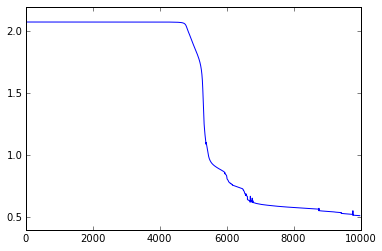

In [11]:
plot(cc[20:])

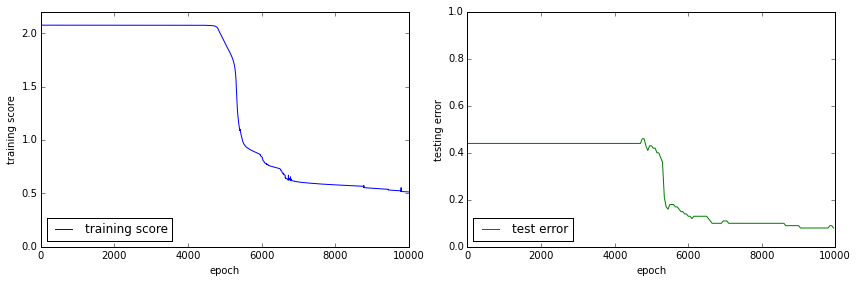

In [12]:
nx = 2
ny = 1
fig = plt.figure(figsize = [6 * nx, 4 * ny]) # inch

ax0 = fig.add_subplot(ny, nx, 1)
plot(cc)
plt.legend(['training score'], loc='lower left')
ax0.set_xlim(0)
ax0.set_ylim(0)
ax0.set_ylabel('training score')
ax0.set_xlabel('epoch')

ax1 = fig.add_subplot(ny, nx, 2)
plot(cc2_idx, cc2, color='g')
plt.legend(['test error'], loc='lower left')
ax1.set_xlim(0)
ax1.set_ylim(0, 1)
ax1.set_ylabel('testing error')
ax1.set_xlabel('epoch')

fig.tight_layout()





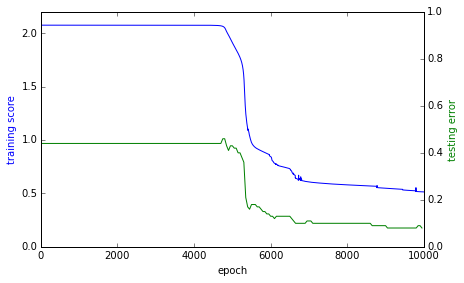

In [13]:
nx = 2
ny = 1
fig = plt.figure(figsize = [6 * nx, 4 * ny]) # inch

ax0 = fig.add_subplot(ny, nx, 1)
plot(cc, color='b')
#plt.legend(['training score'], loc='lower left')
ax0.set_xlim(0)
ax0.set_ylim(0)
ax0.set_ylabel('training score', color='b')
ax0.set_xlabel('epoch')

ax1 = ax0.twinx()
plot(cc2_idx, cc2, color='g')
#plt.legend(['test error'], loc='lower left')
ax1.set_xlim(0)
ax1.set_ylim(0, 1)
ax1.set_ylabel('testing error', color='g')
ax1.set_xlabel('epoch')

fig.tight_layout()